## Tarea 1 -Máquinas de Aprendizaje
#### Yoel Berant - 201604519-8
#### Diego Valderas - 201673549-6

In [38]:
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Perceptron
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, LeaveOneOut
from ipywidgets import interact,interactive, fixed
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, FastICA
import statsmodels.api as sm

## Sección 1. Máquinas de aprendizaje aplicadas a la medicina

En el mundo de la medicina, hacer una predicción correcta a partir de los síntomas de un paciente puede significar la vida o la muerte. Es por eso que la implementación de máquinas de aprendizaje en la medicina tiene una relevancia enorme. En esta sección, se cuenta con un dataset, 'heart', el cual contiene el registro de los síntomas de varios pacientes. El objetivo es desarrollar un modelo capaz de predecir, a partir de los síntomas, si cada uno de los pacientes están en riesgo de un infarto.

A continuación, se importa el dataset:

In [39]:
headers = ['age','sex','chest_pain','blood_p','serum','blood_s','electro','max_heart', 'angina','oldpeak','slope','vessel','thal','normal']
df = pd.read_csv("heart.dat", header=None, names=headers, sep=' ')


df['sex'][df['sex'] == 0] = 'female'
df['sex'][df['sex'] == 1] = 'male'
df['chest_pain'][df['chest_pain'] == 1] = 'typical angina'
df['chest_pain'][df['chest_pain'] == 2] = 'atypical angina'
df['chest_pain'][df['chest_pain'] == 3] = 'non-anginal pain'
df['chest_pain'][df['chest_pain'] == 4] = 'asymptomatic'
df['blood_s'][df['blood_s'] == 0] = 'lower than 120mg/ml'
df['blood_s'][df['blood_s'] == 1] = 'greater than 120mg/ml'
df['electro'][df['electro'] == 0] = 'normal'
df['electro'][df['electro'] == 1] = 'ST-T wave abnormality'
df['electro'][df['electro'] == 2] = 'left ventricular hypertrophy'
df['angina'][df['angina'] == 0] = 'no'
df['angina'][df['angina'] == 1] = 'yes'
df['slope'][df['slope'] == 1] = 'upsloping'
df['slope'][df['slope'] == 2] = 'flat'
df['slope'][df['slope'] == 3] = 'downsloping'
df['thal'][df['thal'] == 3] = 'normal'
df['thal'][df['thal'] == 6] = 'fixed defect'
df['thal'][df['thal'] == 7] = 'reversable defect'
DF=df

FileNotFoundError: File b'heart.dat' does not exist

### a)
A continuación, se representara a la distribución de algunos de los datos cuantitativos del dataset, separados por pacientes normales (fuera de riesgo de infarto) y anormales (en riesgo de infarto):

In [ ]:
#df.boxplot()
df=df.sort_values("blood_p")#IMPORTANTE PARA DESPUÉS
dfn=df.loc[df['normal']==1]#pacientes normales
dfa=df.loc[df['normal']==2]#pacientes anormales
print(df.columns)

In [ ]:
sns.distplot(dfn['age'],kde=True, color='blue', bins=100,label="normal").set(xlabel="edad",ylabel="frecuencia",title="distribución de pacientes según edad")
sns.distplot(dfa['age'],kde=True, color='red', bins=100,label="anormal")
sns.despine()
plt.legend()

Pacientes en riesgo tienen a tener más edad que pacientes normales 

In [ ]:
sns.distplot(dfn['blood_p'],kde=True, color='blue', bins=50,label="normal").set(xlabel="presión sanguinea",ylabel="frecuencia",title="presión sanguinea de pacientes según edad")
sns.distplot(dfa['blood_p'],kde=True, color='red', bins=50,label="anormal")
sns.despine()
plt.legend()

Pacientes normales tienden a registrar presiones más "centradas" a 130 que anormales.

In [ ]:
sns.countplot(x="sex",data=dfn).set(xlabel="presión sanguinea",ylabel="frecuencia",title="presión de sexos de pacientes normales")
sns.despine()
plt.legend()

In [ ]:
sns.countplot(x="sex",data=dfa).set(xlabel="presión sanguinea",ylabel="frecuencia",title="presión de sexos de pacientes anormales")
sns.despine()
plt.legend()

Pacientes hombres parecen tener mayor probabilidad de estar en riesgo que pacientes mujeres.

### b)
Al momento de trabajar con un modelo de aprendizaje, es necesario conocer a las variables con las que se adaptará el modelo. En este caso usaremos un modelo de regresión lineal, el cual solo puede trabajar con variables cuantitativas, es decir, números. Sin embargo, este dataset contiene variables cualitativas que podrían ser significativas al momento de hacer las predicciones, por lo que será necesario representarlas numéricamente. Por ejemplo, nada nos dice que el sexo del paciente no será importante en el diagnóstico final.

Lo primero que a uno se le viene a la mente es asignarle a cada una de las posibles variables cuantitativas un número, en cada categoría cuantitativa. Por ejemplo, si es hombre el valor de sexo será 0 y si es mujer, 1. El problema de hacer esto es que estamos asignando un peso cuantitativo a las variables, las cuales a pesar de originalmente no tienen ninguna relación de "mayor o menor" entre sí, en este caso pasarían a compararse numéricamente según un estándar definido por el que asigna las variables. 

Por ejemplo, consideremos que existe la variable "nacionalidad" (en este caso no existe, es solo hipotéticamente), cuyos posibles valores son "Chile", "EEUU" y "Brazil". Si asignamos a Chile el número 1, a Brazil el número 2 y a EEUU el número 3 (asumiendo que solo hay pacientes de esas nacionalidades), según el modelo, un chileno y un brazilero serán más similares que un chileno y un estadounidense, puesto que el valor 1 está más cercano al 2 que al 3. El problema es que los valores fueron asignados por nosotros y en realidad, no hay ninguna relación de "semejanza" dictada por aquellos valores.

Una solución a este problema es el método "One Hot Vectors". Básicamente es descomponer cada característica cuantitativa en cada una de sus variables, cuyos valores serán igual a 0 en caso de que se cumpla la semejanza valor-característica y 0 en caso contrario.

Por ejemplo, en lugar de que cada paciente tenga un valor "sexo", tendrá dos valores: "sexo_masculino" y "sexo_femenino". En caso de que el paciente sea hombre, sexo_masculino será igual a 1 y sexo_femenino será igual a 0. Si el paciente es mujer, sexo_masculino será igual a 0 y sexo_femenino igual a 1. En nuestro caso de ejemplo, en lugar de que el paciente tenga una nacionalidad, poseerá tres valores: "nacionalidad_chile", "nacionalidad_brazil" y "nacionalidad_EEUU", uno de los cuales será igual a 1 y el resto será igual a 0 dependiendo de la nacionalidad. De esta manera, cada valor posible de la variable pesa lo mismo: ninguno más que otro.

En este caso, el método 'get_dummies' de la librería pandas nos permite hacer eso:


In [ ]:
categorical=df[["sex","vessel","electro","angina","slope","thal","blood_s","chest_pain"]]
df=pd.concat([df,pd.get_dummies(categorical)],axis=1)
#df=df.drop(columns=["sex","blood_p","vessel","electro","angina","slope","thal","blood_s","chest_pain"])
df.columns

### c)
Lo siguiente es preparar la regresión lineal. La variable de clase a predecir será "normal" (0 significa que no hay riesgo de paro, 1 significa que sí) y la variable de regresión será la presión sanguínea. Llamaremos a la matriz pacientes(ejemplos)/variables "X_data":

In [ ]:
class_label = df["normal"].values -1 # 0 means absence, 1 means presence
reg_label = df["blood_p"].values

#borramos los datos categóricos. Recordemos que ya los pasamos a otras columnas cuantitativas con get_dummies:
#,"blood_p","normal"
X_data = df.drop(columns=["sex","vessel","electro","angina","slope","thal","blood_s","chest_pain","blood_p","normal"]).values

### d)
A, continuación, generamos una partición de X_data entre datos de entrenamiento "X_train"(70%) y datos de prueba "X_test"(30%):

In [ ]:
'''
d) Cree un conjunto de pruebas para evaluar los modelos construidos en el problema. Extraiga el 30% de los datos del 
conjunto total para representar el conjunto de pruebas.

'''
#separación de train y test:
np.random.seed(0)
mask_test = np.random.rand(X_data.shape[0]) < 0.30

X_train = X_data[~mask_test] 
X_test = X_data[mask_test] 

#valores esperados de entrenamiento y de prueba
reg_label_train = reg_label[~mask_test] 
reg_label_test = reg_label[mask_test]
class_label_train = class_label[~mask_test]
class_label_test = class_label[mask_test]
print("Train: ",X_train.shape)
print("Test: ",X_test.shape)

### e)
Previo a la regresión, estandarizaremos las variables. Esto permitirá analizar en un futuro cuales variables tienen un mayor impacto en la regresión, sin importar en que "escala" se presenten:

In [ ]:
std = StandardScaler()
std.fit(X_train)
Xstd_train = std.transform(X_train) 
Xstd_test = std.transform(X_test)
print(Xstd_train)

### f)
A continuación, se realiza la regresión lineal; para eso, usaremos a la clase LinearRegression de la librería sklearn. Primero se realiza el entrenamiento con el 70% de los datos originales, y luego, la prueba con los 30% datos restantes.

(Nota: en esta implementación de regresión lineal, se evalúa el conjunto de entrenamiento después, y no durante, el entrenamiento)

In [ ]:
model = LinearRegression(fit_intercept=True)

#entrenamiento:
model.fit(Xstd_train, reg_label_train)
reg_pred_train = model.predict(Xstd_train)
#prueba:
reg_pred_test = model.predict(Xstd_test)

Luego, medimos las pérdidas obtenidas en cada ejemplo, definiendo a la pérdida de cada instancia como: $(\hat{Y}_{i}-Y_{i})^{2}$.

In [ ]:
Etrain=[]
Etest=[]
Ltrain=[]
Ltest=[]

#errores de entrenamiento
for i in range(len(reg_pred_train)):
    error=(reg_label_train[i]-reg_pred_train[i])
    loss=error**2
    Etrain.append(error)
    Ltrain.append(loss)

#errores de predicción
for i in range(len(reg_pred_test)):
    error=(reg_label_test[i]-reg_pred_test[i])
    loss=error**2
    Etest.append(error)
    Ltest.append(loss)


Graficando el error y la pérdida obtenida sobre el conjunto de entrenamiento por iteración:

In [ ]:
xtrain=list(range(1,len(Etrain)+1))


plt.figure(figsize=(8,4))
plt.title("error de entrenamiento")
plt.xlabel("iteraciones")
plt.ylabel("error")
plt.plot(xtrain,Etrain,'g-',label='error de entrenamiento (R)',linewidth=3,alpha=0.5)

plt.figure(figsize=(8,4))
plt.title("pérdida de entrenamiento")
plt.xlabel("iteraciones")
plt.ylabel("pérdida")
plt.plot(xtrain,Ltrain,'r-',label='pérdida de entrenamiento (R)',linewidth=3,alpha=0.5)

Graficando el error y la pérdida obtenida sobre el conjunto de prueba por iteración:

In [ ]:
xtest=list(range(1,len(Etest)+1))

plt.figure(figsize=(8,4))
plt.title("error de prueba")
plt.xlabel("iteraciones")
plt.ylabel("error")
plt.plot(xtest,Etest,'g-',label='error de prueba (R)',linewidth=3,alpha=0.5)

plt.figure(figsize=(8,4))
plt.title("pérdida de prueba")
plt.xlabel("iteraciones")
plt.ylabel("pérdida")
plt.plot(xtrain,Ltrain,'r-',label='pérdida de prueba (R)',linewidth=3,alpha=0.5)

Por último, haremos un análisis de los residuos, en relación a la hipótesis de normalidad, la cual propone que los residuos se comportan como una distribución aleatoria normal. Para eso, ordenaremos los residuos y crearemos qq plots comparándolos cin distribuciones normales.

In [ ]:
residuos_train=reg_label_train-reg_pred_train
residuos_test=reg_label_test-reg_pred_test


sm.qqplot(residuos_train)
plt.plot(np.linspace(-3,3),np.linspace(-40,40))
plt.title("qq plot de residuos comparados con distribución normal en entrenamiento:")
plt.figure()


sm.qqplot(residuos_test)
plt.plot(np.linspace(-3,3),np.linspace(-40,40))
plt.title("qq plot de residuos comparados con distribución normal en prueba:")
plt.figure()

Como se puede ver, los residuos parecen seguir parcialmente a lo que sería una distribución normal, aunque en los extremos suele desviarse. Por otro lado, los residuos generados en el conjunto de entrenamiento tienden más a la normal (el qq plot se ajusta más a la linea) que en el conjunto de prueba.

Revisando los gráficos de error y pérdida obtenidos, y los qq plots, se puede llegar a que las predicciones están lejos ser similares a lo que se espera, puesto que, por ejemplo, los errores de prueba y entrenamiento alcanzan cifras cercanas a 40 (en magnitud) y dichos gráficos presentan muchísimo ruido. Además, los qq plots se alejan mucho de la línea recta de referencia (x=y). En los qq plots, los resultados del conjunto de entrenamiento tuvieron una semejanza mucho mayor a los resultados reales que en el conjunto de prueba. En otras palabras, se presenta overfitting.

### g)
Mediremos los pesos obtenidos del modelo de cada variable, los z-scores y los f-scores.

El z_score de la variable $X_{i}$, con relación a la variable de regresión $Y$ y  se calcula de la siguiente forma:
$$
Z_{i}=\frac{\sum_{l}(x_{i}^{l}-\overline{x_{i}})(y_{i}^{l}-\overline{y})\sqrt{\sum_{l}(x_{i}^{l}-\overline{x_{i}})^{2}}}{\sum_{l}(x_{i}^{l}-\overline{x_{i}})^{2}\sigma^{2}}
$$

Dónde $\sigma$ es la desviación estándar de de los residuos.

Por otro lado, el f_score de la variable $X_{i}$ se calcula como:

$$
F_{i}=\frac{(n-2)\rho(i)^{2}}{1-\rho(i)^{2}}
$$

En este caso, para $\rho(i)$ será igual a:

$$
\rho(i)=\frac{\sum_{l}(x_{i}^{l}-\overline{x_{i}})(y_{i}^{l}-\overline{y})}{\sqrt{var(x_{i})*var(y)}}
$$

Similarmente a los pesos de las variables obtenidos de la regresión lineal, el z-score y el f-score buscan determinar el impacto de las variables en la variable de regresión, en este caso, la presión sanguínea.

Nota: el f-score y el z-score serán obtenidos a partir de la muestra no estandarizada de todos los datos.


In [ ]:
Ws=pd.DataFrame()
vrs={}
i=0
for col in (df.drop(columns=["sex","vessel","electro","angina","slope","thal","blood_s","chest_pain","blood_p","normal"]).columns):
    vrs[col]=model.coef_[i]
    i+=1
Ws["variables"]=vrs.keys()
Ws["pesos"]=vrs.values()

In [ ]:
sigma=np.std(np.concatenate((reg_label_train,reg_label_test))-np.concatenate((reg_pred_train,reg_pred_test)))

def z_score(X_i,Y):
    C=np.cov(X_i,Y)
    a=C[0][1]/C[0][0]
    s=sigma/np.sqrt(C[0][0])
    return a/s

def f_score(X_i,Y):
    n=len(X_i)
    C=np.cov(X_i,Y)
    #rho=C[0][1]/(np.sqrt(C[0][0])*np.sqrt(C[1][1]))
    rho=C[0][1]/np.sqrt(np.var(X_i)*np.var(Y))
    return(n-2)*(rho**2)/(1-rho**2)

In [ ]:
zscrs={}
fscrs={}

cols=list(vrs.keys())
for i in range(X_data.shape[1]):#iterar sobre cada parámetro
    zscrs[cols[i]]=z_score(X_data[:,i],reg_label)
    fscrs[cols[i]]=f_score(X_data[:,i],reg_label)
    

Z=pd.DataFrame()
F=pd.DataFrame()
Z["variables"]=zscrs.keys()
Z["z_scores"]=zscrs.values()
F["variables"]=fscrs.keys()
F["f_values"]=fscrs.values()

In [ ]:
# pesos de variables, ordenados por magnitud
Ws.iloc[Ws['pesos'].abs().argsort()].iloc[::-1]

In [ ]:
# z_scores de variables, ordenados por magnitud
Z.iloc[Z['z_scores'].abs().argsort()].iloc[::-1]

In [ ]:
# f_scores de variables, ordenados por magnitud
F.iloc[F['f_values'].abs().argsort()].iloc[::-1]

El ranking obtenido de evaluar el z_score y f_values es equivalente, puesto que ambos puntajes son proporcionales al valor $\rho(i)$. Por otro lado, el ranking de los pesos es algo distinto a los otros rankings, aunque comparten primer y segundo lugar: age y oldpeak  respectívamente. 

### h)
También se pueden analizar los errores obtenidos de la regresión lineal tanto en el entrenamiento como en las pruebas, medidos como: $((\hat{Y}-Y)^{2})$

In [ ]:
print("MSE train: ", mean_squared_error(reg_label_train, reg_pred_train))
print("MSE test: ", mean_squared_error(reg_label_test, reg_pred_test))

Considerando que estamos hablando de un modelo que, en el entorno de la medicina, trata de predecir la presión sanguínea de un paciente para así diagnosticar un posible de riesgo de ataque cardiaco, no podemos considerar como aceptable un error demasiado grande en un modelo que, en caso de ser usado en la vida real, puede llegar a decidir si una persona vive o muere.

Hay que tener en mente que los errores en este caso fueron calculados usando la diferencia al cuadrado y por ende, debemos analizar sus raíces: aproximadamente 15 y 19. Si estos fueran los rangos de error (en magnitud) quizás podríamos considerar al modelo como aceptable, pero estos son los errores en promedio. Recordando los gráficos hechos en el inciso f), los errores suelen superar mucho estos valores en magnitud.

Por lo tanto, en este caso se consideran a los errores como demasiado significativos para ser aceptables.


### i ) 
Como alternativa, podemos usar la cross validation o validación cruzada. Esta consiste en dividir al conjunto de ejemplos en k grupos, cada uno con la misma cantidad de ejemplos. Luego, en cada una de las k iteraciones, se elige a uno de los conjuntos y se separa del resto. Los otros (k-1) conjuntos serán el conjunto de entrenamiento en donde un modelo de regresión se entrenará (en cada iteración un modelo se entrenará desde cero). El conjunto aislado elegido en cada iteración será el conjunto de prueba.

In [ ]:
def cross_val(K):
    if K==1:
        kf=LeaveOneOut()
    else:
        kf = KFold(n_splits=K)
    mse_cv = 0
    i=0
    for train, val in kf.split(X_data):
        i+=1
        linreg = LinearRegression(fit_intercept=True)
        Xstd_train = std.transform(X_data[train]) 
        Xstd_test = std.transform(X_data[val])
        
        
        linreg.fit(Xstd_train, reg_label[train])
        yhat_kfold_val = linreg.predict(Xstd_test)
        mse_fold =  np.mean( np.square(yhat_kfold_val - reg_label[val]) )
        #print(Xstd_train)
        mse_cv += mse_fold
    mse_cv = mse_cv / K
    #print(i)
    return mse_cv

print('el error cuadrático medio obtenido de la cross validation cuando k=1 (leave one out) es: ',cross_val(1))
print('el error cuadrático medio obtenido de la cross validation cuando k=5 es: ',cross_val(5))

### j)
Una alternativa a la regresión lineal es la regresión ridge. En resumen, se trata de minimizar una pérdida $J_{\alpha}$, la cual está sujeta a una variable $\alpha>0$. Del resultado de la minimización se obtiene:
$$
        minJ_{\lambda}(w)=\sum_{l}(y^{l}-f(x^{l};w))**2+\alpha ||w||^{2}
$$

Por lo tanto, en cada iteración, la variable peso se actualiza:
$$
    w=w-(\triangledown J(w) + \alpha w)
$$

La clase Ridge de a librería sklearn nos permite automatizar todo este proceso.

En este caso, usaremos distintos valores de $\alpha$, desde 1 a $10^{5}$, y veremos los pesos finales obtenidos para cada variable. Como conjunto de entrenamiento, usaremos el mismo que usamos para la primera regresión lineal.

In [ ]:
alphas_ = np.logspace(5,0, base=10)
coefs = []
model = Ridge(fit_intercept=True, solver='svd')

#regresion ridge minimiza j sujeta a un parámetro alpha

for a in alphas_:#distintos parámetros para ajustar la ridge regression
    model.set_params(alpha=a)
    model.fit(Xstd_train, reg_label_train)
    coefs.append(model.coef_)


En el siguiente gráfico, se presentan los pesos obtenidos para cada variable, según el parámetro alpha:

In [ ]:
names_regressors = df.drop(columns=["sex","vessel","electro","angina","slope","thal","blood_s","chest_pain","blood_p","normal"]).columns
plt.figure(figsize=(15,7))
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)
plt.legend()
plt.xscale('log')
plt.xlabel("alphas")
plt.ylabel("pesos")
plt.title('Regularization Path RIDGE')
plt.legend(loc='lower right')
plt.show()


Como se puede observar, el parámetro $\alpha$ "ajusta" a las variables. Entre mayor sea, más equitativos serán los pesos finales. 

Se podría decir que es difícil definir un valor de $\alpha$ óptimo para este caso. Si elegimos un $\alpha$ muy pequeño, la diferencia entre los pesos puede ser demasiada grande causando un posible overfitting en la fase de prueba. Si elegimos un $\alpha$ demasiado grande, los pesos de cada variable se vuelven indiferenciables. Además, hay pesos que cambian de "ranking" cuando varía el valor de $\alpha$. Por ejemplo, slope_fat se vuelve menos importante que slope_downslopping entre los valores 10 y 100 de $\alpha$.

### k)

Otra alternativa es el método "lasso", que modifica la función minimizada en ridge, usando norma 1 en lugar de norma 2:

$$
 minJ_{\lambda}(w)=\sum_{l}(y^{l}-f(x^{l};w))**2+\alpha ||w||
$$

La clase Lasso de la librería sklearn nos da acceso a este tipo de regresión. Haremos el mismo proceso que en el inciso j).

In [ ]:
alphas_ = np.logspace(2,-2,base=10)
coefs = []
model = Lasso(fit_intercept=True)
for a in alphas_:
    model.set_params(alpha=a)
    model.fit(Xstd_train, reg_label_train)
    coefs.append(model.coef_)


Graficando peso obtenido por valor de $\alpha$ por cada variable:

In [ ]:
names_regressors = df.drop(columns=["sex","vessel","electro","angina","slope","thal","blood_s","chest_pain","blood_p","normal"]).columns
plt.figure(figsize=(15,7))
for y_arr, label in zip(np.squeeze(coefs).T, names_regressors):
    plt.plot(alphas_, y_arr, label=label)
plt.legend()
plt.xscale('log')
plt.xlabel("alphas")
plt.ylabel("pesos")
plt.title('Regularization Path RIDGE')
plt.legend(loc='lower right')
plt.show()

Se observa un efecto similar al del ejemplo anterior, con la diferencia que las variables "caen" mucho más rápido. En el ejemplo anterior el $\alpha$ tenía que acercarse a los $10^{5}$ para que las variables converjan a 0. Acá, ya en $\alpha=10$ todas las variables se igualan a 0.

### l)
Con el siguiente widget, podemos comparar cómo se comportan las regresiones Lasso y Ridge frente a distintos valores del parámetro $\alpha$, en cuanto a error (cuadrático).  Usaremos el mismo conjunto de entrenamiento y prueba de los primeros incisos.

In [ ]:
def train_model(param):
    A= 10**(param)
    modelR = Ridge(fit_intercept=True, solver='svd')
    modelL = Lasso(fit_intercept=True)

    print("Parámetro alpha: ",A)
    
    modelR.set_params(alpha=A)
    modelR.fit(Xstd_train, reg_label_train)
    print("error cuadrático promedio de entrenamiento en ridge: ", mean_squared_error(reg_label_train, modelR.predict(Xstd_train) ))
    print("error cuadrádico promedio de prueba en ridge: ", mean_squared_error(reg_label_test, modelR.predict(Xstd_test) ))
    
    modelL.set_params(alpha=A)
    modelL.fit(Xstd_train, reg_label_train)
    print("error cuadrático promedio de entrenamiento en lasso: ", mean_squared_error(reg_label_train, modelL.predict(Xstd_train) ))
    print("error cuadrádico promedio de prueba en lasso: ", mean_squared_error(reg_label_test, modelL.predict(Xstd_test) ))
    
    
    
p_min = -10 #define your range
p_max = 10 #define your range
interactive(train_model, param=(p_min,p_max))

Para valores de $\alpha$ pequeños (menores a 1), observamos que el comportamiento de los errores, tanto de entrenamiento como en prueba de ambas regresiones es casi igual. Lo mismo sucede en valores de $\alpha$ demasiado grandes (cercanos a $10^{10}$)
En general, el error de entrenamiento en ridge es menor al de lasso cuando $\alpha$ es mayor a 1. El error de prueba también suele ser menor en ridge, pero no significativamente.

En conclusión, es mejor usar el modelo de lasso para valores de $\alpha$ no muy grandes y no muy pequeños. En casos extremos, la decisión entre los dos no es muy significativa.

### m)

Muchas veces, el número de variables disponibles en un modelo de regresión es demasiado grande y algunas de las variables podrían no tener suficiente relevancia en la predicción, lo cual podría causar overfitting. Es por eso que conviene seleccionar un subconjunto de las variables más importantes según algún criterio.

En este caso, necesitamos un modelo con solo 5 características (variables) a partir del dataset original, para predecir la presión sanguínea. Para eso, utilizaremos el algoritmo fss, el evalúa distintos subconjuntos de variables (de largo menor o igual a 5). El criterio utilizado consiste en entrenar el modelo usando a las variables en cada subconjunto, evaluar y comparar resultados según el error absoluto promedio.

In [ ]:
def fss(x, y, names_x, k = 10000):
    p = x.shape[1]-1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = list(range(0, p))
    selected = [p]
    current_score = best_new_score = 0.0
    while remaining and len(selected)<k :
        score_candidates = []
        for candidate in remaining:
            model = LinearRegression(fit_intercept=True, n_jobs=1)
            indexes = selected + [candidate]
            x_t = x[:,indexes]
            
            predictions_train = model.fit(x_t, y).predict(x_t)
            residuals_train =  predictions_train - y
            #error_candidate =  np.mean(np.power(residuals_train, 2))
            error_candidate =  np.mean(np.abs(residuals_train))
            
            score_candidates.append((error_candidate, candidate))
        score_candidates.sort()
        score_candidates[:] = score_candidates[::-1]
        best_new_score, best_candidate = score_candidates.pop()
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print(indexes)
        print ("variable seleccionada = ",names_x[best_candidate],", mse = ",best_new_score)
    print ("variables seleccionadas",names_x[selected])
    return selected
'''
features_fss = fss()
need_feat = features_fss[:5]
'''

def evaluate_fss(x_train,x_test,y_train,y_test,names,k):
    selected_indexes=fss(x_train,y_train,names,k)
    selected_x_test=x_test[:,selected_indexes]
    predictions_test=model.fit(selected_x_test,y_test).predict(selected_x_test)
    residuals_test =  predictions_test - y_test
    itrs=list(range(1,len(residuals_test)+1))
    plt.figure(figsize=(15,7))
    plt.plot(itrs,  residuals_test)
    plt.legend()
    plt.xlabel("iteración")
    plt.ylabel("error")
    print("k=",k)
    plt.title("error de prueba usando k variables seleccionadas")
    plt.legend(loc='lower right')
    plt.show()
#print(fss(Xstd_train, reg_label_train,names_regressors,5),resi)

evaluate_fss(Xstd_train,Xstd_test,reg_label_train,reg_label_test,list(vrs.keys()),5)
#interact(evaluate_fss,x_train=Xstd_train,x_test=Xstd_test,y_train=reg_label_train,y_test=reg_label_test,names=list(vrs.keys),k=(1,23,1))

### n)

Otro criterio utilizable en el algoritmo fss, es el "de maximum relavancy minimum redundancy", el cual, dado un conjunto de variables seleccionadas al que llamaremos F (inicialmente vacío), se le agrega la variable $X_{i}$ no perteneciente a F que maximice:

$$
I(Y,X_{i})-\beta\sum_{j\in F}{I(X_{j},X_{i})}
$$

Donde $\beta\geq0$ y la función $I$ evalúa que tan relacionadas están dos variables. En este caso, como implementación de $I$, utilizaremos a la covarianza.

In [ ]:
def modified_fss(x, y, names_x, k = 10000,beta=0.1):
    p = x.shape[1]-1
    index_y=p+1
    k = min(p, k)
    names_x = np.array(names_x)
    remaining = list(range(0, p))
    selected = []#F
    current_score = best_new_score = 0.0
    allvs=np.c_[x,y].T
    C=np.cov(allvs)#matriz de covarianzas

    while remaining and len(selected)<k :
        score_candidates = []
        for candidate in remaining:
            relevance=C[candidate,index_y]#I(Y,X_i)
            for sel in selected:
                relevance-=beta*C[candidate][sel]#I(X_j,X_i)
            score_candidates.append((relevance,candidate))
        score_candidates.sort()
        best_new_score, best_candidate = score_candidates.pop()

        remaining.remove(best_candidate)
        selected.append(best_candidate)
        print ("variable seleccionada = ",names_x[best_candidate],", mse = ",best_new_score)
    print(selected)
    return selected
'''
features_fss = fss()
need_feat = features_fss[:5]
'''

@interact(k=(1,23,1),beta=(0,10,0.5),x_train=fixed(Xstd_train),x_test=fixed(Xstd_test),y_train=fixed(reg_label_train),y_test=fixed(reg_label_test),names=fixed(list(vrs.keys())))
def evaluate_modified_fss(k,beta,x_train,x_test,y_train,y_test,names):
    selected_indexes=modified_fss(x_train,y_train,names,k,beta)
    selected_x_test=x_test[:,selected_indexes]
    predictions_test=model.fit(selected_x_test,y_test).predict(selected_x_test)#la única vez que se entrena el modelo!
    residuals_test =  predictions_test - y_test
    itrs=list(range(1,len(residuals_test)+1))
    plt.figure(figsize=(15,7))
    plt.plot(itrs,  residuals_test)
    plt.legend()
    plt.xlabel("iteración")
    plt.ylabel("error")
    plt.title("error de prueba usando k variables seleccionadas")
    plt.legend(loc='lower right')
    plt.show()



### o)
Para evaluar la efectividad de la selección de atributos, agregaremos atributos artificiales aleatorios al dataset y reduciremos usando el fss modificado del inciso n, antes de evaluar.

In [ ]:
def add_atributes(X_data,d,scl):
    X_fake=X_data
    names_fake=list(vrs.keys())
    vrs_fake=vrs
    for i in range(d):
        lc=np.random.randint(low=1,high=200)#promedio aleatorio
        X_fake=np.c_[X_fake,np.random.normal(loc=lc,scale=scl,size=X_data.shape[0])]
        names_fake.append("fake_"+str(i))
    return X_fake,names_fake

@interact(k=(1,23,1),beta=(0,10,0.5),d=(10,100,5),scl=(0,50,1))
def evaluate_with_artificial(k,beta,d,scl):

    #evaluate_modified_fss(k,beta,X_train,X_test,reg_label_train,reg_label_test,list(vrs.keys()))
    X_fake,names_fake=add_atributes(X_data,d,scl)
    X_fake_train=X_fake[~mask_test]
    X_fake_test=X_fake[mask_test]
    
    evaluate_modified_fss(k,beta,X_fake_train,X_fake_test,reg_label_train,reg_label_test,names_fake)
                        

Durante el proceso de selección de variables luego de la inclusión de variables artificiales, existe la probabilidad de que un número de variables artificiales sean seleccionadas como las k más importantes. Por lo tanto, a medida que se aumenta el número de variables artificiales, se aumenta la tendencia a que la selección se llene más y más de algunas de estas variables, generando resultados con mayor error. Por otro lado, cuando se aumenta la desviación estándar de los valores de las variables, el rango y la "amplitud" (lejanía de los valores al valor 0) del error también aumenta.

### p)
Ahora, en lugar de predecir a la variable de regresión (presión sanguínea), intentaremos predecir a la variable de clase (0=normal o 1=anormal). Para eso, usaremos al modelo de regresión de lasso.

In [ ]:
mask_norm = class_label_train == 0 #sanos
model = Lasso(fit_intercept=True)
model.fit(Xstd_train[mask_norm], reg_label_train[mask_norm])#se entrena con los sanos  o los "normales"
#model.fit(Xstd_train, reg_label_train)#se entrena con los sanos  o los "normales"

blood_p_tr = model.predict(Xstd_train) 
blood_p_te = model.predict(Xstd_test) 


### q) y r)
Una forma de pasar de predicción de regresión a clasificación es definiendo un umbral (considerando que la variable de regresión parece estar relacionada a la de clasificación). Es decir, definiremos dos números $u$ y $U$ ($u<U$). Si la variable de regresión está entre esos dos números, la variable de clasificación esperada será igual 0 (normal). En caso contrario la variable de clasificación esperada será igual a 1. El objetivo es definir correctamente el umbral tal que la clasificación sea suficientemente correcta (en este caso se nos pide).

In [ ]:
sns.distplot(blood_p_tr[mask_norm], label="normal behavior")
sns.distplot(blood_p_tr[~mask_norm], label="ill person behavior")
plt.legend()
plt.show()


def predict_umbr(data, umbral_up, umbral_low):
    preds = []
    for value in data:
        if value > umbral_up or value < umbral_low:
            preds.append(1) #presencia
        else:
            preds.append(0)
    return np.asarray(preds)

def accu(U=130,u=110):#nota: valores default fueron agregados después de probar con muchos
    if u>=U:
        print("error de umbrales")
        return
    pred_train = predict_umbr(blood_p_tr, U, u)
    pred_test = predict_umbr(blood_p_te, U, u)
    actr=accuracy_score(class_label_train, pred_train)
    acte=accuracy_score(class_label_test, pred_test)
    print("Score train: ",actr)
    print("Score test: ",acte)
    print("diferencia score entrenamiento-prueba:",actr-acte)

interact(accu,u=(0,150,2),U=(100,250,2))


Analizando el histograma generado y experimentando con distintos valores de $u$ y $U$, se llega que cuando $U=130$ y $u<110$ (aprox) los scores train y test alcanzan un valor máximo: el puntaje de entrenamiento es cercano a 0.674 y el de prueba es aproximadamente 0.64. Entonces, la diferencia entre error máximo de entrenamiento y de prueba es de aproximadamente 0.034. Claramente la variación de $u$ y $U$ cambia significativamente la precisión del clasificador.

### s)
Como alternativa, en lugar de intentar clasificar desde la variable de regresión, podemos ocupar al perceptrón: un modelo clasificador que, valga la redundancia, predice un atributo de clasificación en lugar de regresión. A continuación, mediremos la eficacia de este:

In [ ]:
model = Perceptron(fit_intercept=True, eta0=1.0, max_iter=1000, n_jobs=-1)
model.fit(Xstd_train, class_label_train)
pred_train = model.predict(Xstd_train) 
pred_test = model.predict(Xstd_test)
actrper=accuracy_score(class_label_train, pred_train)
acteper=accuracy_score(class_label_test, pred_test)
print("Score train: ",actrper)
print("Score test: ",acteper)
print("diferencia score entrenamiento-prueba:",actrper-acteper)

El nivel de exactitud de entrenamiento es cercano a 0.777 y el de prueba es cercano a 0.756. No solo son puntajes mayores, sino que la diferencia entre puntajes de prueba y entrenamiento son más similares, habiendo una diferencia menor, cercana a 0.021 (menos overfitting). En otras palabras, este método es más cercano, sin desmerecer al anterior cuando los valores de umbral son óptimos.

### t)
A continuación, visualizaremos los datos. Para una mayor comprensión, representaremos a los datos usando una técnica llamada PCA, que básicamente realiza una transformación lineal a los datos

In [ ]:
d = 2
pca_model = PCA(n_components=d)
pca_model.fit(Xstd_train)
X_pca_train = pca_model.transform(Xstd_train)
X_pca_test = pca_model.transform(Xstd_test)


mask_norm_train = class_label_train == 0 
X_pca_train_normal=X_pca_train[mask_norm_train]
X_pca_train_anormal=X_pca_train[~mask_norm_train]

mask_norm_test = class_label_test == 0 
X_pca_test_normal=X_pca_test[mask_norm_test]
X_pca_test_anormal=X_pca_test[~mask_norm_test]

plt.figure(figsize=(20,10))
fig, ax = plt.subplots()
ax.scatter(X_pca_train_normal[:,0], X_pca_train_normal[:,1],color='navy',label="normales (entrenamiento)")
ax.scatter(X_pca_test_normal[:,0], X_pca_test_normal[:,1],color='blue',label="normales (prueba)")
ax.scatter(X_pca_train_anormal[:,0], X_pca_train_anormal[:,1],color='darkred',label="anormales (entrenamiento)")
ax.scatter(X_pca_test_anormal[:,0], X_pca_test_anormal[:,1],color='red',label="anormales (prueba)")

ax.legend()
plt.show()

Observando este scatterplot, donde los rojos son de una clase y los azules son de otra, nos percatamos que, a pesar de que hay una tendencia a que cada clase se mantenga a un lado de la figura (rojos a la derecha y azules a la izquierda), no se puede trazar una "línea" que separe a las dos clases, incluso cuando simplificamos los datos al nivel de separarlos en dos clases, puesto que hay rojos que se "escapan" a la zona de los azules y azules que se "escapan" donde los rojos (esto sucede tanto en datos de entrenamiento como en de prueba). Por lo tanto, una clasificación perfecta no existe.

### u)
A continuación, repetiremos el mismo ejercicio hecho en el inciso t, pero esta vez en lugar de usar PCA para la reducción de dimensionalidad, usaremos otro método llamado ICA.

In [ ]:
d = 2
ica_model = FastICA(n_components=d)

ica_model.fit_transform(Xstd_train)
X_ica_train =ica_model.transform(Xstd_train)
X_ica_test = ica_model.transform(Xstd_test)
print(ica_model.transform(Xstd_train).shape)

mask_norm_train = class_label_train == 0 
X_ica_train_normal=X_ica_train[mask_norm_train]
X_ica_train_anormal=X_ica_train[~mask_norm_train]

mask_norm_test = class_label_test == 0 
X_ica_test_normal=X_ica_test[mask_norm_test]
X_ica_test_anormal=X_ica_test[~mask_norm_test]

plt.figure(figsize=(30,12))
fig, ax = plt.subplots()
ax.scatter(X_ica_train_normal[:,0], X_ica_train_normal[:,1],color='navy',label="normales (entrenamiento)")
ax.scatter(X_ica_test_normal[:,0], X_ica_test_normal[:,1],color='blue',label="normales (prueba)")
ax.scatter(X_ica_train_anormal[:,0], X_ica_train_anormal[:,1],color='darkred',label="anormales (entrenamiento)")
ax.scatter(X_ica_test_anormal[:,0], X_ica_test_anormal[:,1],color='red',label="anormales (prueba)")

ax.legend()
plt.show()

Si bien los valores dentro de las dimensiones resultantes son de "magnitudes" diferentes (están en rangos mucho menores), el efecto se repite. Hay una tendencia a que las clases se separen, pero no existe una separación total.

### v)
A continuación, compararemos la precisión del perceptrón cuando la dimensión es igual a 23 (original) y cuando se reduce la dimensionalidad usando PCA:

In [ ]:
@interact(d=(1,23,1))
def evaluate_dimensionality(d):
    
    model = Perceptron(fit_intercept=True, eta0=1.0, max_iter=1000, n_jobs=-1)
    model.fit(Xstd_train, class_label_train)
    pred_train = model.predict(Xstd_train) 
    pred_test = model.predict(Xstd_test)
    actrper=accuracy_score(class_label_train, pred_train)
    acteper=accuracy_score(class_label_test, pred_test)
    print("cuando la dimensión es igual a 23 (original)")
    print("Score train: ",actrper)
    print("Score test: ",acteper)
    print("diferencia score entrenamiento-prueba:",actrper-acteper)
    
    pca_model = PCA(n_components=d)
    pca_model.fit(Xstd_train)
    X_pca_train_d = pca_model.transform(Xstd_train)
    X_pca_test_d = pca_model.transform(Xstd_test)
    
    
    model_d=Perceptron(fit_intercept=True, eta0=1.0, max_iter=1000, n_jobs=-1)
    model_d.fit(X_pca_train_d,class_label_train)
    pred_train_d=model_d.predict(X_pca_train_d)
    pred_test_d=model_d.predict(X_pca_test_d)
    actrperd=accuracy_score(class_label_train, pred_train_d)
    acteperd=accuracy_score(class_label_test, pred_test_d)
    print("\ncuando la dimension es igual a ",d,":")
    print("Score train: ",actrperd)
    print("Score test: ",acteperd)
    print("diferencia score entrenamiento-prueba:",actrperd-acteperd)
    
    
    
    

Al parecer, la reducción de dimensionalidad puede cambiar y hasta mejorar el nivel de predicción del modelo. Ya con d=2 los scores son mayores y la diferencia entre scores de entrenamiento y prueba es menor (menos overfitting).

## Sección 2: Predicción de edad


Se solicita elaborar una máquina capaz de realizar una predicción de la edad de una persona en una foto. Dado el formato con el que se entregan los datos a predecir este problema presentado corresponde a elaborar un clasificador, es decir, dado un input con distintas variables, predecir un output que consiste en asignar una etiqueta, siendo esta un rango etario específico para dicha entrada. Sin embargo se realizará una manipulación de dichos datos para que cada $y_{i}$ sea un valor perteneciente al rango de valores correspondiente a su etiqueta original; por ejemplo, dado un $y_{k}=5$, después de manipular los datos $y_{k} \in [3-6]$.

Para la solución de un problema se realizará un modelo de regresión lineal que será entrenado y testeado a partir de la información de alto nivel dispuesta para la realización se la tarea. Muchos de estos datos correspondientes a matrices, serán de igual manera manipulados y transformados en vectores para una mayor facilidad en su uso.

En primera instancia se cargan los datos y estos son organizados según su naturaleza, siendo estos matrices o vectores.

In [76]:
import scipy.io as sio
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, LeaveOneOut
from ipywidgets import interactive

In [96]:
archivo = sio.loadmat("eventrain.mat")
archivo2 = sio.loadmat("eventest.mat")
data = archivo["trcoll"][0][0] # "trcoll" set de entrenamiento

#print(type(archivo["trcoll"]))
#print(archivo["trcoll"].shape)
#print(type(archivo["trcoll"][0][0]))
#print(archivo["trcoll"][0][0].shape)
#archivo["trcoll"][0][0]['ageClass']
#archivo["trcoll"][0][0]['genClass']
#archivo["trcoll"][0][0]['genFeat']
#archivo["trcoll"][0][0]['faceGist']
#archivo["trcoll"][0][0]['ageGuess1']
#archivo["trcoll"][0][0]['genderGuessNN']
#archivo["trcoll"][0][0]['facePosSize']

#----------------------DATOS------------------------
features      = data[0]            #matriz 3500x15
age           = data[1].flatten()  #vector 3500x1
gender        = data[2].flatten()  #vector 3500x1
ffcoefs       = data[3]            #matriz 3500x37
facegist      = data[4]            #matriz 3500x600
unknown1      = data[5]            #matriz 3500x2989
genderguessnn = data[6].flatten()  #vector 3500x1
ageguess      = data[7].flatten()  #vector 3500x1
facedata      = data[8]            #...
faceposize    = data[9]            #matriz 3500x7
genaccuracies = data[10]           #matriz 3500x2

for i in range(len(age)):
    if age[i] == 1:
        age[i] = random.randint(1,2)
    elif age[i] == 5:
        age[i] = random.randint(3,7)
    elif age[i] == 10:
        age[i] = random.randint(8,12)
    elif age[i] == 16:
        age[i] = random.randint(13,19)
    elif age[i] == 28:
        age[i] = random.randint(20,36)
    elif age[i] == 51:
        age[i] = random.randint(37,65)
    else:
        age[i] = random.randint(66,100)
age = age.tolist()
gender = gender.tolist()
for i in range(len(gender)):
    if gender[i] == 1:
        gender[i]=0
    else:
        gender[i]=1
genderguessnn = genderguessnn.tolist()
ageguess = ageguess.tolist()
xtr = np.array([gender, genderguessnn, ageguess]).T
columns = ["gender","genderguenn","ageguess"]
df = pd.DataFrame(data=xtr, columns=columns)
X_traindata = df.values
unknown1

array([[104, 108, 112, ...,  83,  80,  82],
       [237, 197, 118, ..., 186, 219, 226],
       [ 66,  66,  55, ...,  82,  77,  65],
       ...,
       [ 50,  52,  36, ...,  65,  70,  70],
       [ 63,  48,  62, ..., 148, 153, 157],
       [124, 127, 131, ...,  89, 134, 182]], dtype=uint8)

El siguiente paso consiste en "preparar", separando en los ejemplos las variables correspondientes a las entradas $X$ y las salidas $Y$. Se realizar la regresión lineal. Cabe aclarar que se sigue utilizando el formato de los rangos etarios utilizados por el proveedor de datos, es decir: $1:[0-2]; 5:[3-7]; 10:[8-12]; 16:[13-19]; 28:[20-36]; 51:[37-65]; 75:[66+]$.

Para los datos de entrada del primer modelo predictor se hará uso de solamente los vectores presentes en el dataset, es decir, aquellos que tengan dimensiones $3500x1$.

In [78]:
std = StandardScaler()
std.fit(X_traindata)
Xstd_train = std.transform(X_traindata)

model = LinearRegression(fit_intercept=True)

#entrenamiento:
model.fit(Xstd_train, age)
y_train = model.predict(Xstd_train)

Enseguida se preparan los datos para realizar el "testeo" del modelo previamente entrenado

In [79]:
datatest = archivo2["tecoll"][0][0] # "tecoll" set de prueba
tfeatures      = datatest[0]            #matriz 3500x15
tage           = datatest[1].flatten()  #vector 3500x1
tgender        = datatest[2].flatten()  #vector 3500x1
tffcoefs       = datatest[3]            #matriz 3500x37
tfacegist      = datatest[4]            #matriz 3500x600
tunknown1      = datatest[5]            #matriz 3500x2989
tgenderguessnn = datatest[6].flatten()  #vector 3500x1
tageguess      = datatest[7].flatten()  #vector 3500x1
tfacedata      = datatest[8]            #...
tfaceposize    = datatest[9]            #matriz 3500x7
tgenaccuracies = datatest[10]           #matriz 3500x2

for i in range(len(tage)):
    if tage[i] == 1:
        tage[i] = random.randint(1,2)
    elif tage[i] == 5:
        tage[i] = random.randint(3,7)
    elif tage[i] == 10:
        tage[i] = random.randint(8,12)
    elif tage[i] == 16:
        tage[i] = random.randint(13,19)
    elif tage[i] == 28:
        tage[i] = random.randint(20,36)
    elif tage[i] == 51:
        tage[i] = random.randint(37,65)
    else:
        tage[i] = random.randint(66,100)
tage = tage.tolist()
tgender = tgender.tolist()
for i in range(len(tgender)):
    if tgender[i] == 1:
        tgender[i]=0
    else:
        tgender[i]=1


tgenderguessnn = tgenderguessnn.tolist()
tageguess = tageguess.tolist()
xte = np.array([tgender,tgenderguessnn, tageguess]).T
columns = ["gender","genderguenn","ageguess"]
df_test = pd.DataFrame(data=xte, columns=columns)
X_testdata = df_test.values
print(X_testdata)
std = StandardScaler()
std.fit(X_testdata)
Xstd_test = std.transform(X_testdata)
#prueba:
y_test = model.predict(Xstd_test)

[[ 0.          0.46534653  3.62191781]
 [ 0.          0.34653465 29.77808219]
 [ 0.          0.46534653 32.3890411 ]
 ...
 [ 0.          0.26732673 29.61917808]
 [ 0.          0.57425743 32.57260274]
 [ 0.          0.31683168 20.59452055]]


Finalmente usamos la "mean absolute percentage error" para obtener la pérdida 

In [80]:
Er_tr=[]
Er_te=[]
Loss_tr=[]
Loss_te=[]

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#errores de entrenamiento
for i in range(len(age)):
    error=(age[i]-y_train[i])
    Loss_tr.append(mean_absolute_percentage_error(age[i], y_train[i]))
    Er_tr.append(error)

#errores de predicción
for i in range(len(tage)):
    error=(tage[i]-y_test[i])
    Er_te.append(error)
    Loss_te.append(mean_absolute_percentage_error(tage[i], y_test[i]))
    

Ahora, se realizan los gráficos correspondientes con el fin de poder analizar los resultados:

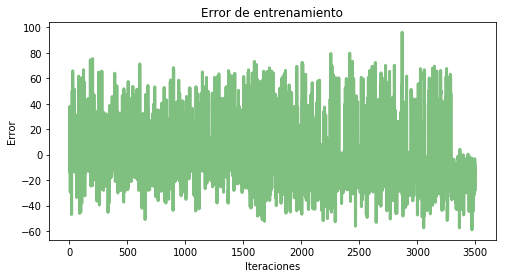

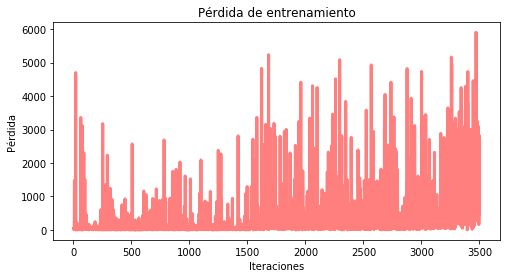

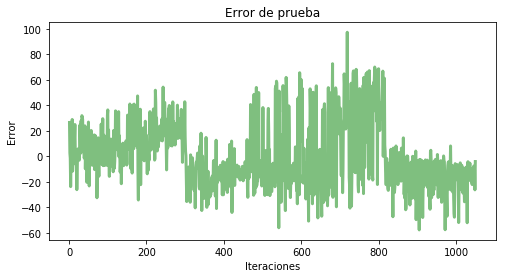

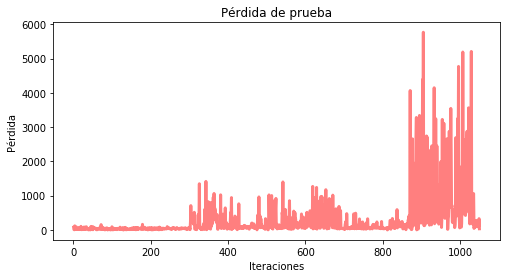

In [81]:
xtrain=list(range(1,len(Er_tr)+1))


plt.figure(figsize=(8,4))
plt.title("Error de entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.plot(xtrain,Er_tr,'g-',label='Error de entrenamiento (R)',linewidth=3,alpha=0.5)

plt.figure(figsize=(8,4))
plt.title("Pérdida de entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.plot(xtrain,Loss_tr,'r-',label='Pérdida de entrenamiento (R)',linewidth=3,alpha=0.5)

xtest=list(range(1,len(Er_te)+1))

plt.figure(figsize=(8,4))
plt.title("Error de prueba")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.plot(xtest,Er_te,'g-',label='Error de prueba (R)',linewidth=3,alpha=0.5)

plt.figure(figsize=(8,4))
plt.title("Pérdida de prueba")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.plot(xtest,Loss_te,'r-',label='Pérdida de prueba (R)',linewidth=3,alpha=0.5)

De los gráficos es posible apreciar que el rendimiento tanto en el entrenamiento como en el testeo difieren uno del otro, siendo mucho más notoria la diferencia al graficar la pérdida. Además, el error que estos presentan es bastante alto demostrando la poca precisión que tiene el algoritmo; desde aquí podemos apreciar que, a pesar de que los valores reales correspondían a un rango etario, situación que permite un pequeño error, cuya magnitud no supera, en promedio, las diez unidades, para el valor predicho, los valores que se obtuvieron con el set de prueba suelen sobrepasar este error "permitido". Este bajo rendimiento se puede relacionar a la poca influencia que tienen los datos ocupados para el entrenamiento dentro del resultado precedido.

Sin embargo, se puede rescatar que el rendimiento para el set de prueba es mucho mejor para la predicción en el conjunto de testeo que en el conjunto de datos de entrenamiento. Dicho resultado puede estar relacionado con que la cantidad de datos usados para la prueba es menor que la cantidad usada para el entrenamiento, dando lugar a una menor varianza entre los datos nombrados al principio. 

Para la pérdida de prueba podemos notar un extraño comportamiento en las últimas iteraciones, el cual puede ser consecuencia de overfitting.

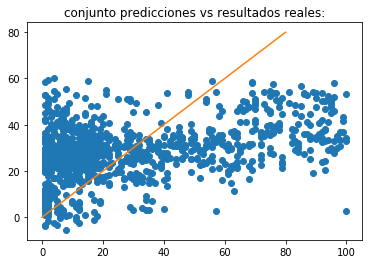

In [82]:
plt.plot(tage,y_test.tolist(),'o')
plt.title("conjunto predicciones vs resultados reales:")
plt.plot(np.linspace(0,80),np.linspace(0,80))

<ErrorbarContainer object of 3 artists>

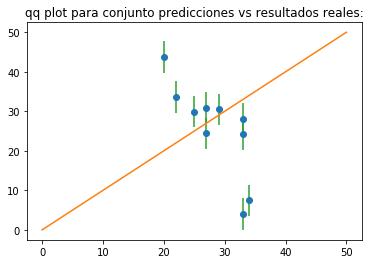

In [83]:
y_testmenosdenso = y_test.tolist()[:10]
tage_menosdenso = tage[:10]
plt.plot(tage_menosdenso,y_testmenosdenso, 'o')
plt.title("qq plot para conjunto predicciones vs resultados reales:")
plt.plot(np.linspace(0,50),np.linspace(0,50))
plt.errorbar(tage_menosdenso,y_testmenosdenso, yerr=4,fmt=' ')

En el gráfico qq que compara los valores predichos con los reales se aprecia de manera más evidente que aun considerando los errores aceptable que se desprenden de los rangos etarios correspondientes a $Y$, los valores predichos varían mucho más que en dicho error previamente nombrado.

Buscando obtener nuevos resultados, se realiza un nuevo modelo con respecto a otras características de las imágenes. Estas son las correspondientes a la matriz "facePosSize" que contiene distintas características acerca de las caras y las posiciones de estas con respecto a la cámara con la cual fue tomada la foto. Principalmente se escogen estos datos ya que influyen directamente en la composición de la cara, factor principal para predecir la apariencia.

In [84]:
age
faceposize
columns2 = ["leftEyeX", "leftEyeY" ,"rightEyeX", "rightEyeY", "Xcenter", "YCenter", "EyeDistance"]
df2 = pd.DataFrame(data=faceposize, columns=columns2)
X2_traindata=df2.values
X2_traindata
std = StandardScaler()
std.fit(X2_traindata)
X2std_train = std.transform(X2_traindata)

model = LinearRegression(fit_intercept=True)

#entrenamiento:
model.fit(X2std_train, age)
y2_train = model.predict(X2std_train)

#test:
tfaceposize
df2_test = pd.DataFrame(data=tfaceposize, columns=columns2)
X2_testdata = df2_test.values
std = StandardScaler()
std.fit(X2_testdata)
X2std_test = std.transform(X2_testdata)
#prueba:
y2_test = model.predict(X2std_test)

#errores y pérdidas:
Er_tr2=[]
Er_te2=[]
Loss_tr2=[]
Loss_te2=[]

#errores de entrenamiento
for i in range(len(age)):
    error=(age[i]-y2_train[i])
    Loss_tr2.append(mean_absolute_percentage_error(age[i], y2_train[i]))
    Er_tr2.append(error)

#errores de predicción
for i in range(len(tage)):
    error=(tage[i]-y2_test[i])
    Er_te2.append(error)
    Loss_te2.append(mean_absolute_percentage_error(tage[i], y2_test[i]))

Dados los resultados, se realizan los gráficos previamente hecho con el fin de contrastar los nuevos resultados con los ya obtenidos en el primer modelo.

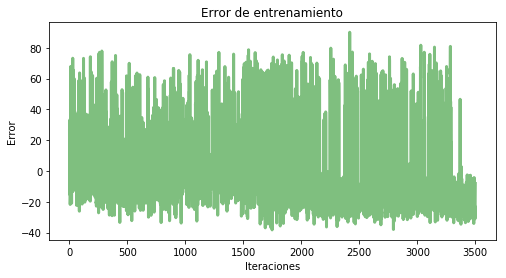

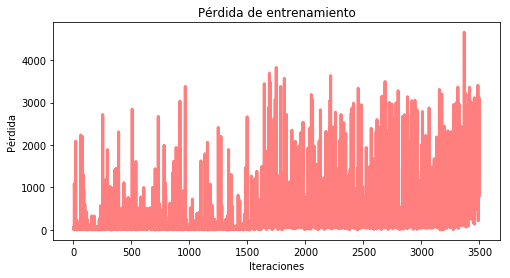

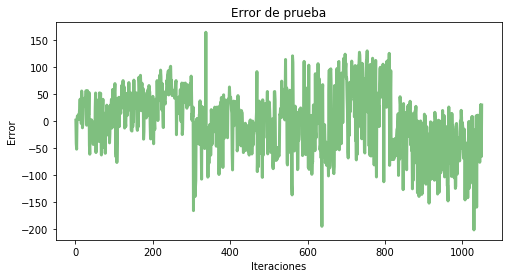

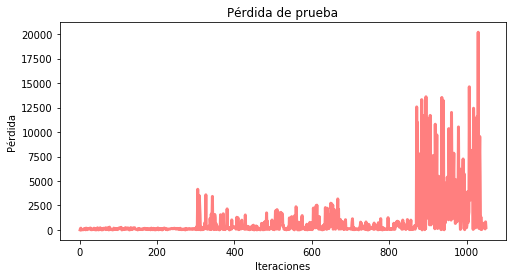

In [85]:
x2train=list(range(1,len(Er_tr2)+1))


plt.figure(figsize=(8,4))
plt.title("Error de entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.plot(x2train,Er_tr2,'g-',label='Error de entrenamiento (R)',linewidth=3,alpha=0.5)

plt.figure(figsize=(8,4))
plt.title("Pérdida de entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.plot(x2train,Loss_tr2,'r-',label='Pérdida de entrenamiento (R)',linewidth=3,alpha=0.5)

x2test=list(range(1,len(Er_te2)+1))

plt.figure(figsize=(8,4))
plt.title("Error de prueba")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.plot(x2test,Er_te2,'g-',label='Error de prueba (R)',linewidth=3,alpha=0.5)

plt.figure(figsize=(8,4))
plt.title("Pérdida de prueba")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.plot(x2test,Loss_te2,'r-',label='Pérdida de prueba (R)',linewidth=3,alpha=0.5)

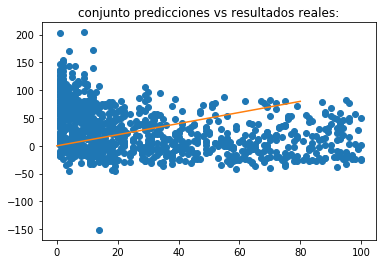

In [86]:
plt.plot(tage,y2_test.tolist(),'o')
plt.title("conjunto predicciones vs resultados reales:")
plt.plot(np.linspace(0,80),np.linspace(0,80))



<ErrorbarContainer object of 3 artists>

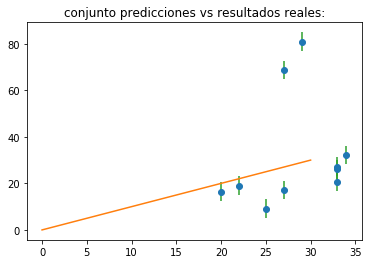

In [87]:
y2_testmenosdenso = y2_test.tolist()[:10]
tage_menosdenso = tage[:10]
plt.plot(tage_menosdenso,y2_testmenosdenso, 'o')
plt.title("conjunto predicciones vs resultados reales:")
plt.plot(np.linspace(0,30),np.linspace(0,30))
plt.errorbar(tage_menosdenso,y2_testmenosdenso, yerr=4,fmt=' ')

Los resultados obtenidos son bastante similares a los obtenidos con anterioridad cuando a los errores respecta. Se puede apreciar un aumento en el mayor valor presente correspondiente al error de prueba para el segundo modelo, superando en varias miles de unidades a la anterior solución. 

El modelo sigue presentando un comportamiento anómalo de la pérdida a medida que aumentan las iteraciones. +

La diferencia para ambos modelos es apreciable en el graficos que contrapone los $y$ reales con los $\hat{y}$ 

Para finalizar se realizará un último modelo que utilizará otro conjunto de datos relacionado con características faciales. Esta vez hablamos de la matriz ffcoefs, donde cada fila es una proyección de dicha cara (la correspondiente a la fila) dentro de un espacio fisherFace.

In [88]:
age
ffcoefs
df3 = pd.DataFrame(data=ffcoefs)
X3_traindata = df3.values
X3_traindata
std = StandardScaler()
std.fit(X3_traindata)
X3std_train = std.transform(X3_traindata)

model = LinearRegression(fit_intercept=True)

#entrenamiento:
model.fit(X3std_train, age)
y3_train = model.predict(X3std_train)

#test:
tffcoefs
df3_test = pd.DataFrame(data=tffcoefs)
X3_testdata = df3_test.values
std = StandardScaler()
std.fit(X3_testdata)
X3std_test = std.transform(X3_testdata)
#prueba:
y3_test = model.predict(X3std_test)

#errores y pérdidas:
Er_tr3=[]
Er_te3=[]
Loss_tr3=[]
Loss_te3=[]

#errores de entrenamiento
for i in range(len(age)):
    error=(age[i]-y3_train[i])
    Loss_tr3.append(mean_absolute_percentage_error(age[i], y3_train[i]))
    Er_tr3.append(error)

#errores de predicción
for i in range(len(tage)):
    error=(tage[i]-y3_test[i])
    Er_te3.append(error)
    Loss_te3.append(mean_absolute_percentage_error(tage[i], y3_test[i]))

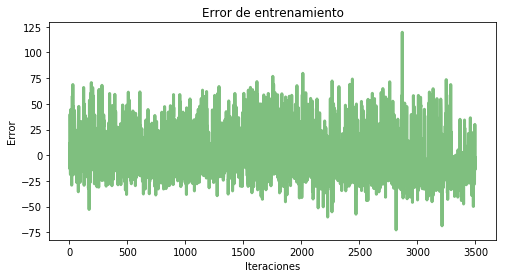

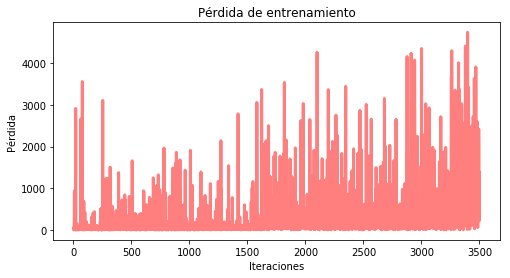

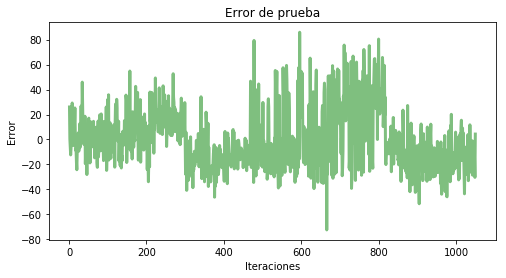

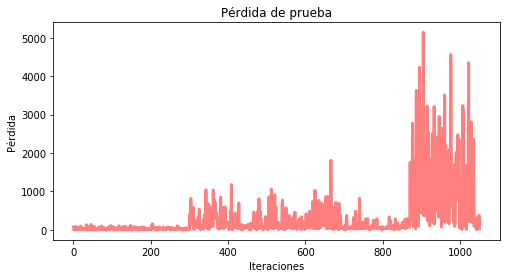

In [89]:
x3train=list(range(1,len(Er_tr3)+1))


plt.figure(figsize=(8,4))
plt.title("Error de entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.plot(x3train,Er_tr3,'g-',label='Error de entrenamiento (R)',linewidth=3,alpha=0.5)

plt.figure(figsize=(8,4))
plt.title("Pérdida de entrenamiento")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.plot(x3train,Loss_tr3,'r-',label='Pérdida de entrenamiento (R)',linewidth=3,alpha=0.5)

x3test=list(range(1,len(Er_te3)+1))

plt.figure(figsize=(8,4))
plt.title("Error de prueba")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.plot(x3test,Er_te3,'g-',label='Error de prueba (R)',linewidth=3,alpha=0.5)

plt.figure(figsize=(8,4))
plt.title("Pérdida de prueba")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.plot(x3test,Loss_te3,'r-',label='Pérdida de prueba (R)',linewidth=3,alpha=0.5)

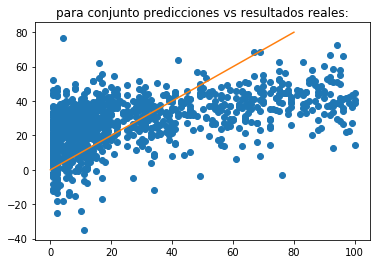

In [90]:
plt.plot(tage,y3_test.tolist(),'o')
plt.title("para conjunto predicciones vs resultados reales:")
plt.plot(np.linspace(0,80),np.linspace(0,80))


<ErrorbarContainer object of 3 artists>

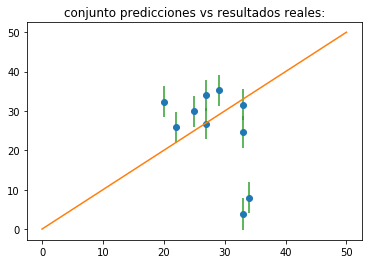

In [91]:
y3_testmenosdenso = y3_test.tolist()[:10]
tage_menosdenso = tage[:10]
plt.plot(tage_menosdenso,y3_testmenosdenso, 'o')
plt.title("conjunto predicciones vs resultados reales:")
plt.plot(np.linspace(0,50),np.linspace(0,50))
plt.errorbar(tage_menosdenso,y3_testmenosdenso, yerr=4,fmt=' ')

Según los gráficos en los que se muestra la pérdida y los errores, los resultados obtenidos para el tercer modelo siguen la misma línea que los otros dos modelos propuestos con anterioridad, pero al momento de ver la comparación entre los valores reales y aquellos estimados, se puede distinguir un pequeño aumento en la concentración alrededor de la recta 𝑦=𝑥 siendo este el punto en que los ejemplos 𝑦=𝑦̂ 
En conclusión, los conjuntos de datos influyen de manera similar sobre el resultado final obtenido, no obteniendo en ningún caso optimalidad para la predicción con respecto a las pérdidas y errores.

Se concluyen que los datos correspondientes a FacePosSize provoca una fuerte pérdida pasadas las 800 iteraciones, mientras que para los datos usado en el primer y tercer modelo, si bien exite una pérdida, esta es mucho menor. 

Finalmente no se logra generalizar de buena manera ya que el error sobrepasa los límites impuestos por los rangos etarios, y se alejan bastante de las edades aleatorias obtenidas mediante la temprana manipulación de los datos.